In [1]:
import os
import re
import time
import json
import sqlglot
import replicate
import datasets
from replicate import Client as rc
from dotenv import load_dotenv
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn3
from IPython.display import display, clear_output

from eval import SQLEval


from sqlglot.errors import (
    ExecuteError,
    TokenError,
    SchemaError,
    ExecuteError,
    ParseError,
    UnsupportedError,
    SqlglotError,
    OptimizeError,
)

# Load environment variables from .env file
load_dotenv("../.env")

# Now you can get the loaded environment variable using os.environ
GITHUB_GIST_TOKEN = os.environ.get("GITHUB_GIST_TOKEN")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
REPLICATE_API_TOKEN = os.environ.get("REPLICATE_API_TOKEN")
REPLICATE_LLAMA_7B_TUNED = os.environ.get("REPLICATE_LLAMA_7B_TUNED")
REPLICATE_LLAMA_7B_BASE = os.environ.get("REPLICATE_LLAMA_7B_BASE")

sqe = SQLEval()

# Load The Inferences

This data can be downloaded from [here](https://huggingface.co/datasets/alagaesia/auto-sql-create-context/blob/main/rich_testing_subset_llama_13b_1_0_0_inferences.zip) and should soon be available for direct download from the Hub in a programmatic fashion. 

In [2]:
inference_data = Dataset.load_from_disk("../../local_data/rich_testing_subset_llama_13b_1_0_0_inferences_three_b")

print("Loaded inference data")
print("The dataset has {} rows and {} columns".format(inference_data.num_rows, inference_data.num_columns))
inference_data

Loaded inference data
The dataset has 300 rows and 27 columns


Dataset({
    features: ['answer', 'context', 'question', 'table_count', 'column_types', 'duplicate_create_table', 'filler_data', 'query_result', 'valid_query', 'openai_inference', 'openai_result', 'openai_valid', 'tuning_format', 'replicate_inference', 'llama_2_13b_base_inference', 'mistral_response', 'replicate_result', 'replicate_valid', 'llama_2_13b_base_result', 'llama_2_13b_base_valid', 'mistral_7b_base_result', 'mistral_7b_base_valid', 'openai_correct', 'replicate_correct', 'openai_replicate_match', 'llama_2_13b_base_correct', 'mistral_7b_base_correct'],
    num_rows: 300
})

In [5]:
inference_data[0]['tuning_format']

'{"prompt": "[INST] <<SYS>>\\nContext contains the relevant SQL tables, respond with the SQL query that answers the Question.\\n<</SYS>>\\n\\nContext: CREATE TABLE table_21991074_3 (pts_agst INTEGER)\\n\\nQuestion: Name the most points agst[/INST]\\n\\n", "completion": "SELECT MAX(pts_agst) FROM table_21991074_3"}'

## Run Initial Validation on Initial Inference Results

In [71]:
inference_data = inference_data.map(sqe.validate_replicate_query)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

### First Evaluation 

First, we will simply get a count of how many queries that were returned were valid. These responses are from inferences that have no data clearning applied to them. To collect this data, we will run the inference query against the sample data using `sqglot`. 

In [73]:
inference_data = inference_data.map(sqe.validate_openai_query)

inference_data = inference_data.map(sqe.validate_replicate_query)
inference_data = inference_data.map(sqe.validate_replicate_query, fn_kwargs={"query_label": "llama_2_13b_base_inference", "result_label": "llama_2_13b_base_result", "valid_label": "llama_2_13b_base_valid"})
inference_data = inference_data.map(sqe.validate_replicate_query, fn_kwargs={"query_label": "mistral_response", "result_label": "mistral_7b_base_result", "valid_label": "mistral_7b_base_valid"})

inference_data = inference_data.map(sqe.inference_result_check)
inference_data = inference_data.map(sqe.custom_inference_result_check, fn_kwargs={"column_result_label": "llama_2_13b_base_result", "outcome_label": "llama_2_13b_base_correct"})
inference_data = inference_data.map(sqe.custom_inference_result_check, fn_kwargs={"column_result_label": "mistral_7b_base_result", "outcome_label": "mistral_7b_base_correct"})

openai_valid_queries = inference_data.filter(lambda x: x["openai_valid"] == True)
replicate_valid_queries = inference_data.filter(lambda x: x["replicate_valid"] == True)
llama_13b_base_valid_queries = inference_data.filter(lambda x: x["llama_2_13b_base_valid"] == True)
mistral_7b_base_valid_queries = inference_data.filter(lambda x: x["mistral_7b_base_valid"] == True)

openai_valid_results = inference_data.filter(lambda x: x["openai_correct"] == True)
replicate_valid_results = inference_data.filter(lambda x: x["replicate_correct"] == True)
llama_13b_base_valid_results = inference_data.filter(lambda x: x["llama_2_13b_base_correct"] == True)
mistral_7b_base_valid_results = inference_data.filter(lambda x: x["mistral_7b_base_correct"] == True)

print("OpenAI valid queries: {}".format(openai_valid_queries.num_rows))
print("Replicate valid queries: {}".format(replicate_valid_queries.num_rows))
print("LLAMA 13b base valid queries: {}".format(llama_13b_base_valid_queries.num_rows))
print("Mistral 7b base valid queries: {}".format(mistral_7b_base_valid_queries.num_rows))

print("OpenAI valid results: {}".format(openai_valid_results.num_rows))
print("Replicate valid results: {}".format(replicate_valid_results.num_rows))
print("LLAMA 13b base valid results: {}".format(llama_13b_base_valid_results.num_rows))
print("Mistral 7b base valid results: {}".format(mistral_7b_base_valid_results.num_rows))

print("\nAs a percentage of total queries: \n")
print("OpenAI valid queries: {:.2f}%".format(100 * openai_valid_queries.num_rows / inference_data.num_rows))
print("Replicate valid queries: {:.2f}%".format(100 * replicate_valid_queries.num_rows / inference_data.num_rows))
print("LLAMA 13b base valid queries: {:.2f}%".format(100 * llama_13b_base_valid_queries.num_rows / inference_data.num_rows))
print("Mistral 7b base valid queries: {:.2f}%".format(100 * mistral_7b_base_valid_queries.num_rows / inference_data.num_rows))

print("OpenAI valid results: {:.2f}%".format(100 * openai_valid_results.num_rows / inference_data.num_rows))
print("Replicate valid results: {:.2f}%".format(100 * replicate_valid_results.num_rows / inference_data.num_rows))
print("LLAMA 13b base valid results: {:.2f}%".format(100 * llama_13b_base_valid_results.num_rows / inference_data.num_rows))
print("Mistral 7b base valid results: {:.2f}%".format(100 * mistral_7b_base_valid_results.num_rows / inference_data.num_rows))

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

OpenAI valid queries: 278
Replicate valid queries: 251
LLAMA 13b base valid queries: 0
Mistral 7b base valid queries: 183
OpenAI valid results: 215
Replicate valid results: 162
LLAMA 13b base valid results: 0
Mistral 7b base valid results: 129

As a percentage of total queries: 

OpenAI valid queries: 92.67%
Replicate valid queries: 83.67%
LLAMA 13b base valid queries: 0.00%
Mistral 7b base valid queries: 61.00%
OpenAI valid results: 71.67%
Replicate valid results: 54.00%
LLAMA 13b base valid results: 0.00%
Mistral 7b base valid results: 43.00%


## Parse Valid SQL Responses from Replicate

At first, we see substantially better results from `gpt-3.5-turbo` in comparison to `llama-2-13b-sql`. Upon further inspection of the data, it is clear that `llama-2-13b-sql` oftentimes fails to properly format the inference in a way that can be directly consumed by our query engine. To correct for this, we will apply simple `regex` formatting. 

In [74]:
%%capture
# sometimes we enounter a cache error, so we split the data into groups and then recombine for the final analysis
replicate_valid_queries = inference_data.filter(lambda x: x["replicate_valid"] == True)
replicate_invalid_queries = inference_data.filter(lambda x: x["replicate_valid"] == False)

replicate_valid_queries = replicate_valid_queries.map(sqe.replicate_response_parser)
replicate_invalid_queries = replicate_invalid_queries.map(sqe.replicate_response_parser)

replicate_valid_queries = replicate_valid_queries.map(sqe.validate_replicate_query)
replicate_invalid_queries = replicate_invalid_queries.map(sqe.validate_replicate_query)

replicate_valid_queries = replicate_valid_queries.map(sqe.inference_result_check)
replicate_invalid_queries = replicate_invalid_queries.map(sqe.inference_result_check)

inference_data = datasets.concatenate_datasets([replicate_valid_queries, replicate_invalid_queries])

In [75]:
inference_data = inference_data.map(sqe.replicate_response_parser)
inference_data = inference_data.map(sqe.replicate_response_parser, fn_kwargs={"inference_label": "llama_2_13b_base_inference", "result_label": "llama_2_13b_base_result", "valid_label": "llama_2_13b_base_valid"})
inference_data = inference_data.map(sqe.replicate_response_parser, fn_kwargs={"inference_label": "mistral_response", "result_label": "mistral_7b_base_result", "valid_label": "mistral_7b_base_valid"})

inference_data = inference_data.map(sqe.validate_openai_query)

inference_data = inference_data.map(sqe.validate_replicate_query)
inference_data = inference_data.map(sqe.validate_replicate_query, fn_kwargs={"query_label": "llama_2_13b_base_inference", "result_label": "llama_2_13b_base_result", "valid_label": "llama_2_13b_base_valid"})
inference_data = inference_data.map(sqe.validate_replicate_query, fn_kwargs={"query_label": "mistral_response", "result_label": "mistral_7b_base_result", "valid_label": "mistral_7b_base_valid"})

inference_data = inference_data.map(sqe.inference_result_check)
inference_data = inference_data.map(sqe.custom_inference_result_check, fn_kwargs={"column_result_label": "llama_2_13b_base_result", "outcome_label": "llama_2_13b_base_correct"})
inference_data = inference_data.map(sqe.custom_inference_result_check, fn_kwargs={"column_result_label": "mistral_7b_base_result", "outcome_label": "mistral_7b_base_correct"})

openai_valid_queries = inference_data.filter(lambda x: x["openai_valid"] == True)
replicate_valid_queries = inference_data.filter(lambda x: x["replicate_valid"] == True)
llama_13b_base_valid_queries = inference_data.filter(lambda x: x["llama_2_13b_base_valid"] == True)
mistral_7b_base_valid_queries = inference_data.filter(lambda x: x["mistral_7b_base_valid"] == True)

openai_valid_results = inference_data.filter(lambda x: x["openai_correct"] == True)
replicate_valid_results = inference_data.filter(lambda x: x["replicate_correct"] == True)
llama_13b_base_valid_results = inference_data.filter(lambda x: x["llama_2_13b_base_correct"] == True)
mistral_7b_base_valid_results = inference_data.filter(lambda x: x["mistral_7b_base_correct"] == True)

print("OpenAI valid queries: {}".format(openai_valid_queries.num_rows))
print("Replicate valid queries: {}".format(replicate_valid_queries.num_rows))
print("LLAMA 13b base valid queries: {}".format(llama_13b_base_valid_queries.num_rows))
print("Mistral 7b base valid queries: {}".format(mistral_7b_base_valid_queries.num_rows))

print("OpenAI valid results: {}".format(openai_valid_results.num_rows))
print("Replicate valid results: {}".format(replicate_valid_results.num_rows))
print("LLAMA 13b base valid results: {}".format(llama_13b_base_valid_results.num_rows))
print("Mistral 7b base valid results: {}".format(mistral_7b_base_valid_results.num_rows))

print("\nAs a percentage of total queries: \n")
print("OpenAI valid queries: {:.2f}%".format(100 * openai_valid_queries.num_rows / inference_data.num_rows))
print("Replicate valid queries: {:.2f}%".format(100 * replicate_valid_queries.num_rows / inference_data.num_rows))
print("LLAMA 13b base valid queries: {:.2f}%".format(100 * llama_13b_base_valid_queries.num_rows / inference_data.num_rows))
print("Mistral 7b base valid queries: {:.2f}%".format(100 * mistral_7b_base_valid_queries.num_rows / inference_data.num_rows))

print("OpenAI valid results: {:.2f}%".format(100 * openai_valid_results.num_rows / inference_data.num_rows))
print("Replicate valid results: {:.2f}%".format(100 * replicate_valid_results.num_rows / inference_data.num_rows))
print("LLAMA 13b base valid results: {:.2f}%".format(100 * llama_13b_base_valid_results.num_rows / inference_data.num_rows))
print("Mistral 7b base valid results: {:.2f}%".format(100 * mistral_7b_base_valid_results.num_rows / inference_data.num_rows))

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

OpenAI valid queries: 278
Replicate valid queries: 251
LLAMA 13b base valid queries: 133
Mistral 7b base valid queries: 191
OpenAI valid results: 215
Replicate valid results: 162
LLAMA 13b base valid results: 76
Mistral 7b base valid results: 131

As a percentage of total queries: 

OpenAI valid queries: 92.67%
Replicate valid queries: 83.67%
LLAMA 13b base valid queries: 44.33%
Mistral 7b base valid queries: 63.67%
OpenAI valid results: 71.67%
Replicate valid results: 54.00%
LLAMA 13b base valid results: 25.33%
Mistral 7b base valid results: 43.67%


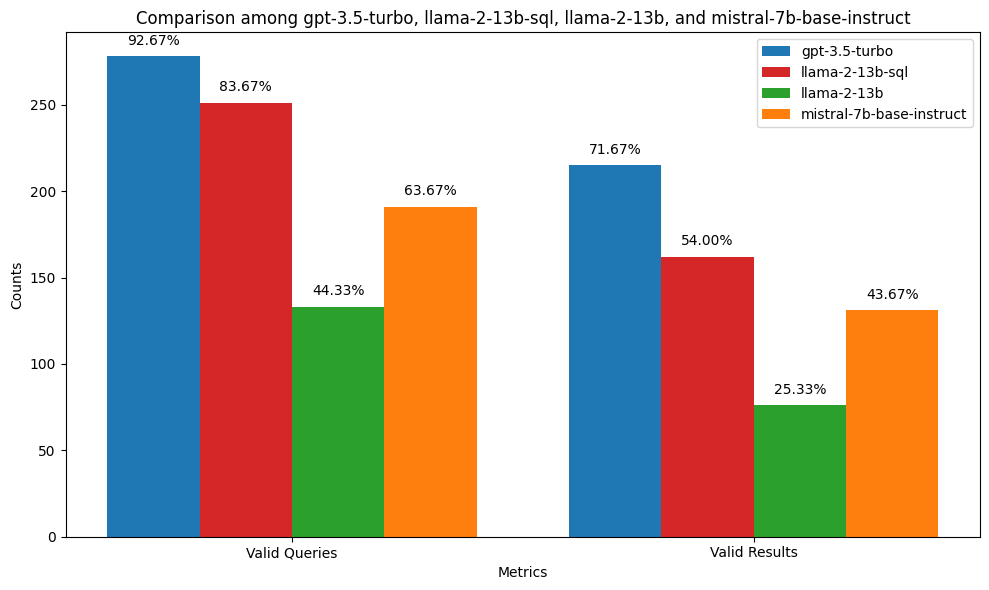

In [78]:
import numpy as np
import matplotlib.pyplot as plt

categories = ['Valid Queries', 'Valid Results']
openai_values = [openai_valid_queries.num_rows, openai_valid_results.num_rows]
replicate_values = [replicate_valid_queries.num_rows, replicate_valid_results.num_rows]
llama_13b_base_values = [llama_13b_base_valid_queries.num_rows, llama_13b_base_valid_results.num_rows]
mistral_7b_base_values = [mistral_7b_base_valid_queries.num_rows, mistral_7b_base_valid_results.num_rows]

openai_percentages = [100 * openai_valid_queries.num_rows / inference_data.num_rows,
                      100 * openai_valid_results.num_rows / inference_data.num_rows]

replicate_percentages = [100 * replicate_valid_queries.num_rows / inference_data.num_rows,
                         100 * replicate_valid_results.num_rows / inference_data.num_rows]

llama_13b_base_percentages = [100 * llama_13b_base_valid_queries.num_rows / inference_data.num_rows,
                                100 * llama_13b_base_valid_results.num_rows / inference_data.num_rows]

mistral_7b_base_percentages = [100 * mistral_7b_base_valid_queries.num_rows / inference_data.num_rows,
                                100 * mistral_7b_base_valid_results.num_rows / inference_data.num_rows]

x = np.arange(len(categories))  # the label locations
width = 0.2  # Adjusted width of the bars for 4 sets

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar charts for absolute values
ax1.bar(x - 1.5 * width, openai_values, width, color='tab:blue', label='gpt-3.5-turbo')
ax1.bar(x - 0.5 * width, replicate_values, width, color='tab:red', label='llama-2-13b-sql')
ax1.bar(x + 0.5 * width, llama_13b_base_values, width, color='tab:green', label='llama-2-13b')
ax1.bar(x + 1.5 * width, mistral_7b_base_values, width, color='tab:orange', label='mistral-7b-base-instruct')  # New set

# Labeling and other aesthetics
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Counts')
ax1.set_title('Comparison among gpt-3.5-turbo, llama-2-13b-sql, llama-2-13b, and mistral-7b-base-instruct')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()

# Adding percentages on top of the bars
for i in range(len(categories)):
    ax1.text(i - 1.5 * width, openai_values[i] + 5, f"{openai_percentages[i]:.2f}%", ha='center', va='bottom', color='black', rotation=0)
    ax1.text(i - 0.5 * width, replicate_values[i] + 5, f"{replicate_percentages[i]:.2f}%", ha='center', va='bottom', color='black', rotation=0)
    ax1.text(i + 0.5 * width, llama_13b_base_values[i] + 5, f"{llama_13b_base_percentages[i]:.2f}%", ha='center', va='bottom', color='black', rotation=0)
    ax1.text(i + 1.5 * width, mistral_7b_base_values[i] + 5, f"{mistral_7b_base_percentages[i]:.2f}%", ha='center', va='bottom', color='black', rotation=0)  # New set

plt.tight_layout()
plt.show()


# How did they Differ?

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

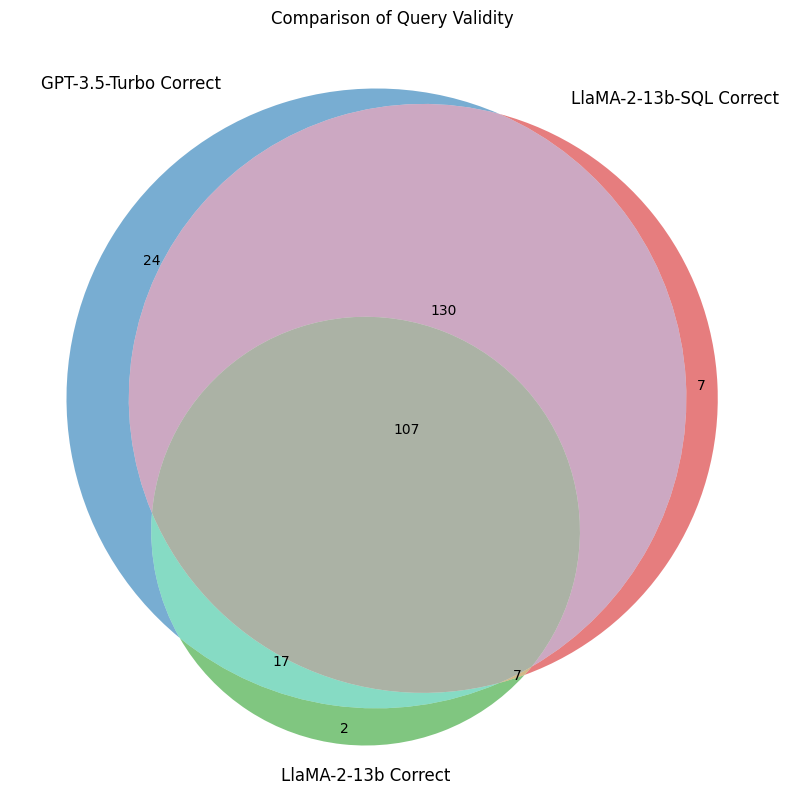

In [17]:
# Define the filters for all intersections:
only_openai_valid = inference_data.filter(lambda x: x["openai_valid"] == True and x["replicate_valid"] == False and x["llama_2_13b_base_valid"] == False)
only_llama_sql_valid = inference_data.filter(lambda x: x["openai_valid"] == False and x["replicate_valid"] == True and x["llama_2_13b_base_valid"] == False)
only_llama_base_valid = inference_data.filter(lambda x: x["openai_valid"] == False and x["replicate_valid"] == False and x["llama_2_13b_base_valid"] == True)
openai_and_llama_sql_not_base = inference_data.filter(lambda x: x["openai_valid"] == True and x["replicate_valid"] == True and x["llama_2_13b_base_valid"] == False)
openai_and_llama_base_not_sql = inference_data.filter(lambda x: x["openai_valid"] == True and x["replicate_valid"] == False and x["llama_2_13b_base_valid"] == True)
llama_sql_and_llama_base_not_openai = inference_data.filter(lambda x: x["openai_valid"] == False and x["replicate_valid"] == True and x["llama_2_13b_base_valid"] == True)
all_three_valid = inference_data.filter(lambda x: x["openai_valid"] == True and x["replicate_valid"] == True and x["llama_2_13b_base_valid"] == True)

# Compute the counts for the subsets:
Abc = only_openai_valid.num_rows
aBc = only_llama_sql_valid.num_rows
abC = only_llama_base_valid.num_rows
ABc = openai_and_llama_sql_not_base.num_rows
AbC = openai_and_llama_base_not_sql.num_rows
aBC = llama_sql_and_llama_base_not_openai.num_rows
ABC = all_three_valid.num_rows

# Plotting the Venn diagram:
plt.figure(figsize=(10, 10))
venn3(subsets=(Abc, aBc, ABc, abC, AbC, aBC, ABC),
      set_labels=('GPT-3.5-Turbo Correct', 'LlaMA-2-13b-SQL Correct', 'LlaMA-2-13b Correct'),
      set_colors=('tab:blue', 'tab:red', 'tab:green'),
      alpha=0.6)

plt.title("Comparison of Query Validity")
plt.show()


Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

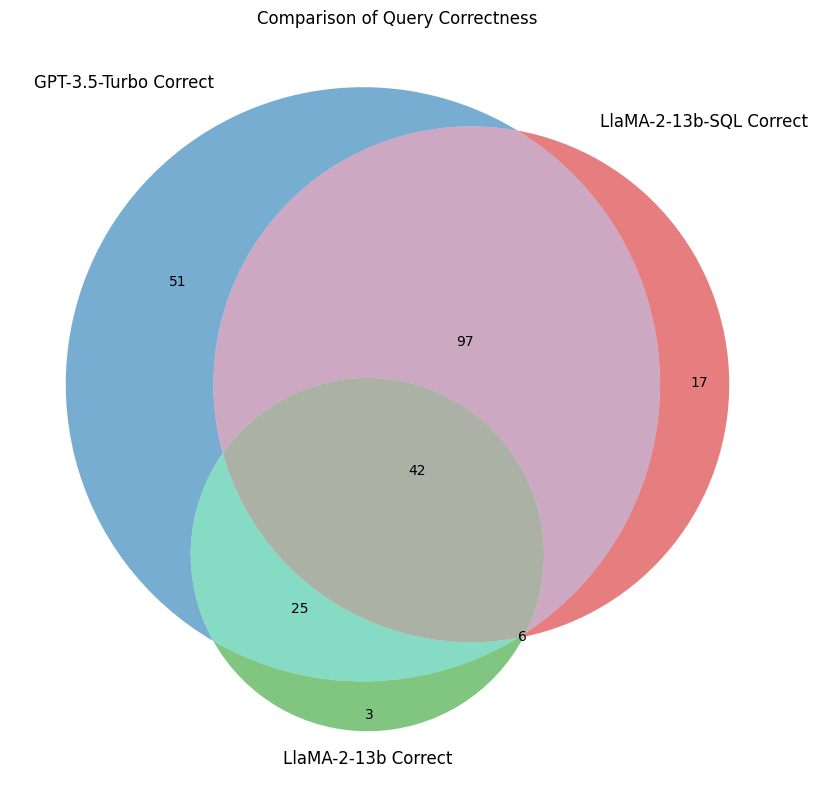

In [18]:
# Define the filters for all intersections:
only_openai_correct = inference_data.filter(lambda x: x["openai_correct"] == True and x["replicate_correct"] == False and x["llama_2_13b_base_correct"] == False)
only_llama_sql_correct = inference_data.filter(lambda x: x["openai_correct"] == False and x["replicate_correct"] == True and x["llama_2_13b_base_correct"] == False)
only_llama_base_correct = inference_data.filter(lambda x: x["openai_correct"] == False and x["replicate_correct"] == False and x["llama_2_13b_base_correct"] == True)
openai_and_llama_sql_not_base = inference_data.filter(lambda x: x["openai_correct"] == True and x["replicate_correct"] == True and x["llama_2_13b_base_correct"] == False)
openai_and_llama_base_not_sql = inference_data.filter(lambda x: x["openai_correct"] == True and x["replicate_correct"] == False and x["llama_2_13b_base_correct"] == True)
llama_sql_and_llama_base_not_openai = inference_data.filter(lambda x: x["openai_correct"] == False and x["replicate_correct"] == True and x["llama_2_13b_base_correct"] == True)
all_three_correct = inference_data.filter(lambda x: x["openai_correct"] == True and x["replicate_correct"] == True and x["llama_2_13b_base_correct"] == True)

# Compute the counts for the subsets:
Abc = only_openai_correct.num_rows
aBc = only_llama_sql_correct.num_rows
abC = only_llama_base_correct.num_rows
ABc = openai_and_llama_sql_not_base.num_rows
AbC = openai_and_llama_base_not_sql.num_rows
aBC = llama_sql_and_llama_base_not_openai.num_rows
ABC = all_three_correct.num_rows

# Plotting the Venn diagram:
plt.figure(figsize=(10, 10))
venn3(subsets=(Abc, aBc, ABc, abC, AbC, aBC, ABC),
      set_labels=('GPT-3.5-Turbo Correct', 'LlaMA-2-13b-SQL Correct', 'LlaMA-2-13b Correct'),
      set_colors=('tab:blue', 'tab:red', 'tab:green'),
      alpha=0.6)
plt.title("Comparison of Query Correctness")
plt.show()

general thoughts on the model evaluation 
- [x] would have liked to have seen the base line results 
- [x] would have liked to have seen the loss curve 
- would have liked to have seen some example outputs from these things 

would have liked to have seen more baseline comparisons
- would have liked to have seen some better paper comparisons 
- would have liked to have seen hyper parameter tuning 